In [1]:
import os
# os.environ['DEVICE_ID'] = '0'
import numpy as np
import mindspore as ms
#导入mindspore中context模块，用于配置当前执行环境，包括执行模式等特性。
import mindspore.context as context
#c_transforms模块提供常用操作，包括OneHotOp和TypeCast
import mindspore.dataset.transforms.c_transforms as C
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
import mindspore.dataset.vision.c_transforms as CV

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import LossMonitor
# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target='CPU') # Ascend, CPU, GPU

In [2]:
def create_dataset(data_dir, training=True, batch_size=32, resize=(32, 32),
                   rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    data_train = os.path.join(data_dir, 'train') # 训练集信息
    data_test = os.path.join(data_dir, 'test') # 测试集信息
    ds = ms.dataset.MnistDataset(data_train if training else data_test)
    #将操作中的每个操作应用到此数据集。
    ds = ds.map(input_columns=["image"], operations=[CV.Resize(resize), CV.Rescale(rescale, shift), CV.HWC2CHW()])
    ds = ds.map(input_columns=["label"], operations=C.TypeCast(ms.int32))
    # When `dataset_sink_mode=True` on Ascend, append `ds = ds.repeat(num_epochs) to the end
    ds = ds.shuffle(buffer_size=buffer_size).batch(batch_size, drop_remainder=True)

    return ds

[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:12:27.640.390 [mindspore\dataset\core\validator_helpers.py:804] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:12:27.643.354 [mindspore\dataset\core\validator_helpers.py:804] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:12:27.645.348 [mindspore\dataset\core\validator_helpers.py:804] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:12:27.647.344 [mindspore\dataset\core\validator_helpers.py:804] 'TypeCas

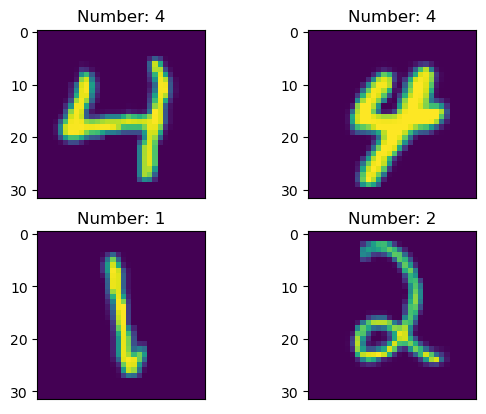

In [3]:
import matplotlib.pyplot as plt
ds = create_dataset('E:\DeepLearning\LeNet\MNIST', training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()
#显示前4张图片以及对应标签
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(images[i][0])
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()


In [4]:
#定义LeNet5模型
class LeNet5(nn.Cell):
    def __init__(self):
        super(LeNet5, self).__init__()
        #设置卷积网络（输入输出通道数，卷积核尺寸，步长，填充方式）
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, pad_mode='valid')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(400, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, 10)
    #构建网络
    def construct(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


In [5]:
def train(data_dir, lr=0.01, momentum=0.9, num_epochs=3):
    ds_train = create_dataset(data_dir)
    ds_eval = create_dataset(data_dir, training=False)

    net = LeNet5()
    #计算softmax交叉熵。
    loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    #设置Momentum优化器
    opt = nn.Momentum(net.trainable_params(), lr, momentum)
    loss_cb = LossMonitor(per_print_times=ds_train.get_dataset_size())

    model = Model(net, loss, opt, metrics={'acc', 'loss'})
    # dataset_sink_mode can be True when using Ascend
    model.train(num_epochs, ds_train, callbacks=[loss_cb], dataset_sink_mode=True)
    metrics = model.eval(ds_eval, dataset_sink_mode=True)
    print('Metrics:', metrics)

train('MNIST')

[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:44:34.647.142 [mindspore\dataset\core\validator_helpers.py:804] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:44:34.648.139 [mindspore\dataset\core\validator_helpers.py:804] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:44:34.649.136 [mindspore\dataset\core\validator_helpers.py:804] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(2104:19900,MainProcess):2022-11-06-22:44:34.650.135 [mindspore\dataset\core\validator_helpers.py:804] 'TypeCas

epoch: 1 step: 1875, loss is 2.2783474922180176
epoch: 2 step: 1875, loss is 0.25742995738983154
epoch: 3 step: 1875, loss is 0.025048408657312393
Metrics: {'loss': 0.09282013977047963, 'acc': 0.97265625}


In [1]:

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
 
# --------------------------------------【配置神经网络结构相关的参数】-------------------------------------------
# MNIST数据集相关的常数
INPUT_NODE = 784  # 输入层节点数，因为图片是28*28*1的格式，每个像素点对应一个节点就是784
OUTPUT_NODE = 10  # 输出层节点数，0-9十个数字
 
# 图片相关参数
IMAGE_SIZE = 28   # 图片大小
NUM_CHANNELS = 1  # 通道数
NUM_LABELS = 10   # 标签数量
 
 
# 第一层卷积神经网络配置（深度和尺寸）
CONV1_DEEP = 32
CONV1_SIZE = 5
# 第二层卷积神经网络配置（深度和尺寸）
CONV2_DEEP = 64
CONV2_SIZE = 5
# 全连接层的节点个数
FC_SIZE = 512
 
BATCH_SIZE = 100  # Batch的大小
LEARNING_RATE_BASE = 0.8  # 基础学习率
LEARNING_RATE_DECAY = 0.99  # 学习率衰减速率
REGULARIZATION_RATE = 0.0001  # L2正则化参数（描述模型复杂度的正则化项在损失函数中的系数(lambda）
TRAINING_STEPS = 3000  # 训练轮数
MOVING_AVERAGE_DECAY = 0.99  # 滑动平均衰减率，decay
 
 
# ---------------------------------------------定义前向传播过程--------------------------------------------
def inference(input_tensor, train, regularizer):
    # 第一层，卷积层
    # 声明第一层卷积层的变量并实现前向传播过程，
    # 通过使用不同的命名空间来隔离不同层的变量，这可以让每一层中的变量命名只需要考虑在当前层的作用，不用担心重名的问题
    # 和标准的LeNet-5模型不大一样，这定义的卷积层输入为28*28*1的原始MNIST图片像素。
    # 卷积核大小5*5，深度为16，步长为1，,使用全0填充，输出为28*28*32的矩阵
    with tf.variable_scope('layer1-conv1'):
        # conv1_weights的大小为5*5*1*32
        conv1_weights = tf.get_variable("weight", [CONV1_SIZE, CONV1_SIZE, NUM_CHANNELS, CONV1_DEEP],
                                        initializer=tf.truncated_normal_initializer(stddev=0.1))
        # conv1_biases的大小为32
        conv1_biases = tf.get_variable("bias", [CONV1_DEEP],
                                       initializer=tf.constant_initializer(0.0))
        # 计算卷积层：边长为5，深度为32，步长为1，且用全0填充
        conv1 = tf.nn.conv2d(input_tensor, conv1_weights, strides=[1, 1, 1, 1], padding="SAME")
        # 注意这里tf.nn.bias_add函数，函数给每一个节点加上偏置项
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
 
    # 第二层，池化层
    # 实现第二层的前向传播。这里选用最大池化层，池化层的过滤器边长为2，步长为2，且使用全0补充
    # 这一层的输入是上一层的输出，即28*28*32的矩阵，输出为14*14*32的矩阵
    with tf.variable_scope('layer2-pool1'):
        pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
 
    # 第三层，卷积层
    # 这一层的输入为14*14*32的矩阵
    # # 卷积核大小5*5，深度为64，步长为1，,使用全0填充，输出为14*14*64的矩阵
    with tf.variable_scope('layer3-conv2'):
        # conv2_weights的大小为5*5*32*64
        conv2_weights = tf.get_variable("weight", [CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP],
                                        initializer=tf.truncated_normal_initializer(stddev=0.1))
        # conv2_biases的大小为64
        conv2_biases = tf.get_variable("bias", [CONV2_DEEP], initializer=tf.constant_initializer(0.0))
        # 卷积运算
        conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding="SAME")
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
 
    # 第四层，池化层
    # 这里选用最大池化层，池化层的过滤器边长为2，步长为2，且使用全0补充
    # 输入为14*14*64，输出为7*7*64
    with tf.variable_scope('layer4-pool2'):
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
 
    # 将第四层的输出转化为第五层全连接层的输入格式。第四层的输出7*7*64的矩阵，然而第五层全连接层需要的输入格式为向量，
    # 所以在这里需要将这个7*7*64的矩阵拉直成一个向量。
    with tf.variable_scope('flatten'):
        fla = tf.contrib.layers.flatten(pool2)
        nodes = fla.shape[1]
 
    # 第五层，全连接层
    # 输入是拉直后的一组向量，长度为3136，输出时一组长度为512的向量
    # 这里引入了dropout，dropout在训练时会随机将部分节点的输出改为0.dropout可以避免过拟合问题，
    # 从而使得模型在测试数据上的效果更好
    # dropout一般只在全连接层使用，卷积层或者池化层不使用
    with tf.variable_scope('layer5-fc1'):
        fc1_weights = tf.get_variable("weight", [nodes, FC_SIZE],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        # 只有全连接层的权重需要加入正则化
        if regularizer is not None:
            tf.add_to_collection('losses', regularizer(fc1_weights))
 
        fc1_biases = tf.get_variable('bias', [FC_SIZE], initializer=tf.constant_initializer(0.1))
        fc1 = tf.nn.relu(tf.matmul(fla, fc1_weights) + fc1_biases)
        if train:
            fc1 = tf.nn.dropout(fc1, 0.5)
 
    # 第六岑，输出层
    # 输入为长度为512的向量，输出为一组长度为10的向量，这一层的输出通过Softmax之后就得到了最后的分类结果
    with tf.variable_scope('layer6-fc2'):
        fc2_weights = tf.get_variable("weight", [FC_SIZE, NUM_LABELS],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer is not None:
            tf.add_to_collection('losses', regularizer(fc2_weights))
        fc2_biases = tf.get_variable("bias", [NUM_LABELS], initializer=tf.constant_initializer(0.1))
        logit = tf.matmul(fc1, fc2_weights) + fc2_biases
 
    # 返回第六层输出
    return logit
 
 
# -------------------------定义向后传播和训练过程（包括损失函数的计算，最终预测）-------------------------------
def train(mnist):
    """训练模型"""
    # 定义额输入输出placeholder
    x = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS], name="x-input")
    y_ = tf.placeholder(tf.float32, shape=[None, OUTPUT_NODE], name="y-input")
 
    # 定义正则化的方法
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    # 向前传播求出y
    y = inference(x, False, regularizer)
 
    # 定义存储训练轮数的变量。这个变量不需要计算滑动平均值，所以这里指定这个变量为不可训练的变量（trainable=False）
    # 在使用TensorFlow训练神经网络时，一般会将代表训练轮数的变量指定为不可训练的参数
    global_step = tf.Variable(0, trainable=False)
 
    # 给定滑动平均衰减速率和训练轮数，初始化滑动平均类
    # 定训练轮数的变量可以加快训练前期的迭代速度
    variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
 
    # 用tf.trainable_variable()获取所有可以训练的变量列表，全部使用滑动平均
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
 
    # 定义损失函数
    # 因为标准答案是一个长度为10的一维数组，argmax可以从这个矩阵（y_）的轴为1的部分取最大值的序号
    # 注意前面已经热点化答案了，所以最大值为1，其他值为0
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
    # 获取总损失平均值
    cross_entropy_mean = tf.reduce_mean(cross_entropy)
 
    # 给损失加上正则化的损失
    # 使用get_collection获取losses集合的全部值的列表，然后用add_n求列表的所有值的和
    loss = cross_entropy_mean + tf.add_n(tf.get_collection("losses"))
 
    # 求加上指数衰减的学习率
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,
        global_step,
        mnist.train.num_examples / BATCH_SIZE,
        LEARNING_RATE_DECAY,
        staircase=True
    )
 
    # 优化损失函数
    # global_step初始值为0，在loss更新后会+1，用来记录更新的次数
    # 返回值是训练之后的梯度，会随着global_step递增
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
    # 反向传播更新参数之后需要更新每一个参数的滑动平均值，用下面的代码可以一次完成这两个操作
    with tf.control_dependencies([train_step, variables_averages_op]):
        train_op = tf.no_op(name="train")
 
    # y是计算得出的预测答案，而y_是正确答案，用argmax获取答案的序号（也即是数字的值）
    # equal()判断两个答案是否相等，是就返回True，否就返回False
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    # cast()把一个布尔类型的数转换为实数，然后用reduce_mean计算平均值，获取准确率
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
 
    # 开启会话，计算
    with tf.Session() as sess:
        # 初始化全局变量
        tf.global_variables_initializer().run()
        for i in range(TRAINING_STEPS):
            # tensorflow的数据集特有的一种batch_size获取方法
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            xs = np.reshape(xs, (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
            _, loss_value, step = sess.run([train_op, loss, global_step], feed_dict={x: xs, y_: ys})
            if i % 1000 == 0:
                print("After %d training step(s), loss on training batch is %g" % (step, loss_value))
                test_x, test_y = mnist.test.next_batch(1000)
                test_x = test_x.reshape(-1, 28, 28, 1)
                train_acc = accuracy.eval(feed_dict={x: test_x, y_: test_y})
                print(train_acc)
 
 

ModuleNotFoundError: No module named 'tensorflow'